In [1]:
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from timm.models.hub import download_cached_file
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt

MODEL_URL = "https://github.com/Boram3J/image-editing/releases/download/inpainting/big-lama-344c77bb.pt"


def load_model(device="cpu", progress=True):
    model_path = download_cached_file(MODEL_URL, progress=progress)
    model = torch.jit.load(model_path, map_location="cpu")
    model.to(device)
    model.eval()
    return model


def load_images(root="inpainting", size=(256, 384)):
    imgs = [Image.open(p) for p in Path(root).glob("*.jpg")]
    if size is not None:
        imgs = [img.resize(size, Image.Resampling.LANCZOS) for img in imgs]
    return imgs


torch.manual_seed(1)


Text(0.5, 1.0, 'Original Images')

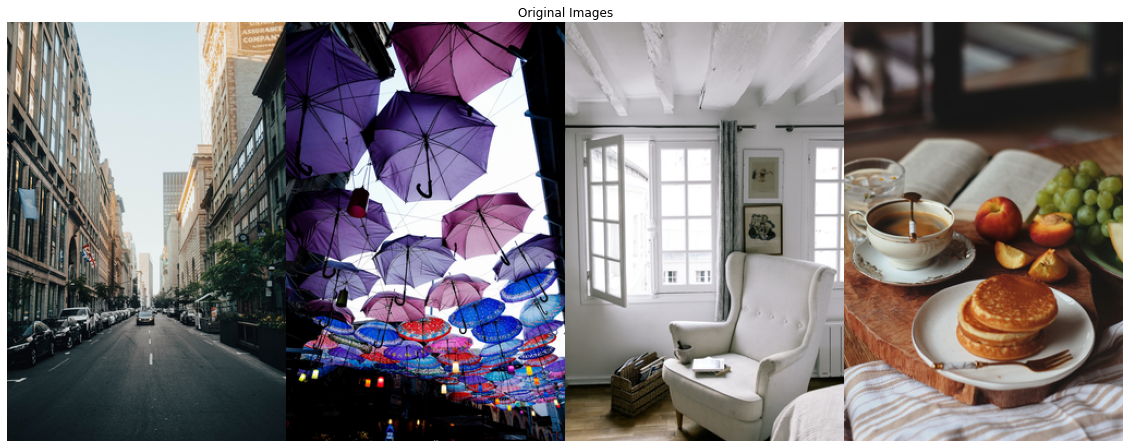

In [2]:
imgs = load_images()
plt.figure(figsize=(20, 20))
plt.imshow(np.hstack([np.asarray(img) for img in imgs]))
plt.axis("off")
plt.title("Original Images")


Text(0.5, 1.0, 'Erased Images')

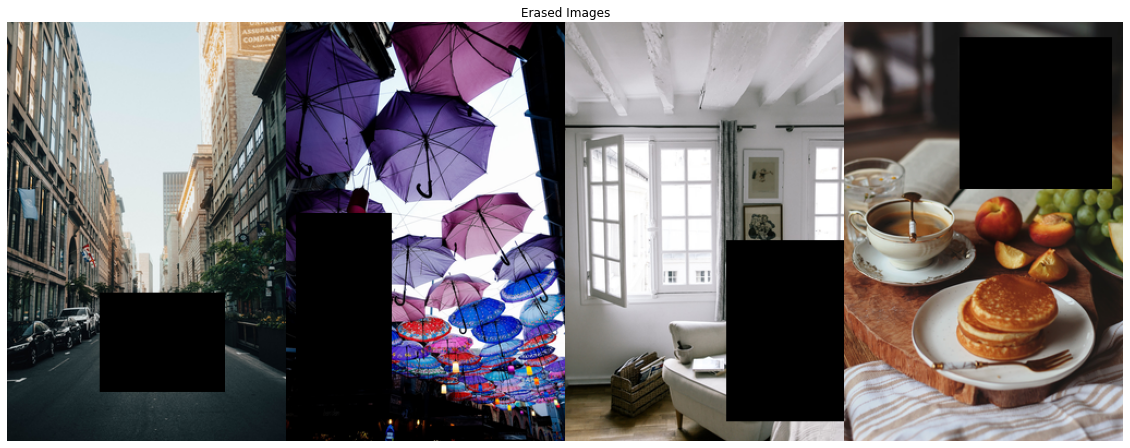

In [3]:
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.RandomErasing(p=1),
    ]
)
erased = [transform(img) for img in imgs]
plt.figure(figsize=(20, 20))
plt.imshow(np.hstack([np.asarray(to_pil_image(img)) for img in erased]))
plt.axis("off")
plt.title("Erased Images")


Text(0.5, 1.0, 'Inpainted Images')

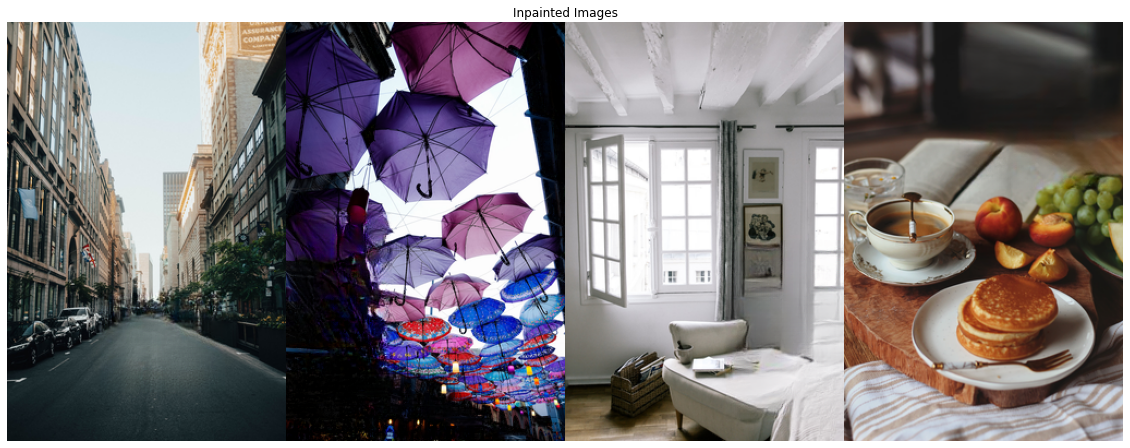

In [4]:
device = "cpu"
model = load_model(device=device)
inp = torch.stack(erased, dim=0).to(device)
msk = inp[:, :1] < torch.finfo(inp.dtype).eps
with torch.inference_mode():
    out = model(inp, msk.long()).cpu()
plt.figure(figsize=(20, 20))
plt.imshow(np.hstack([np.asarray(to_pil_image(img)) for img in out]))
plt.axis("off")
plt.title("Inpainted Images")
